In [1]:
import numpy as np
from numpy import pi,sqrt,std

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import utils
import imp
imp.reload(utils)

<module 'utils' from 'utils.pyc'>

In [2]:
# load cosmological 21cm, Ly-alpha, and H-alpha power spectra at z=7

d = '/home/abrahamn/21cmIRxcor/3Dsensitivitycalculations/models/'

# Ly-alpha
gongdat = np.genfromtxt(d+'Gong14/gong_lyalpha_model_pspec_upperlimit_z=7.csv',delimiter=',',skip_header=3)
gong_k_upper = gongdat[:,0]
gong_Delta_kjy_per_sr_upperlimit = np.sqrt(gongdat[:,1])*1.e-3  # taking the square root, then multiplying by 1.e-3 
                                                      # converts from (Jy/sr)^2 to (kJy/sr)

gongdat = np.genfromtxt(d+'Gong14/gong_lyalpha_model_pspec_lowerlimit_z=7.csv',delimiter=',',skip_header=3)
gong_k_lower = gongdat[:,0]
gong_Delta_kjy_per_sr_lowerlimit = np.sqrt(gongdat[:,1])*1.e-3

# load vanilla 21cmFAST power spectrum from Pober 14 (what can 21cm observatories teach us about reionization?)
#poberdat = np.genfromtxt(d+'Pober14/P21_Delta^2_mK^2_late_reionization.csv',delimiter=',',skip_header=3)
poberdat = np.genfromtxt(d+'Pober14/P21_Delta^2_mK^2_later_reionization.csv',delimiter=',',skip_header=3)
pober_k_upperlimit = poberdat[:,0]
pober_Delta_K_upperlimit = np.sqrt(poberdat[:,1])*1.e-3 # taking the square root and multiplying by 1.e-3 
                                                      # converts from mK^2 to K
    
poberdat = np.genfromtxt(d+'Pober14/P21_Delta^2_mK^2_fiducial.csv',delimiter=',',skip_header=3)
pober_k_lowerlimit = poberdat[:,0]
pober_Delta_K_lowerlimit = np.sqrt(poberdat[:,1])*1.e-3

# let's interpolate all these models onto the the same k values
model_k = pober_k_lowerlimit
pober_Delta_K_lowerlimit_model_k = pober_Delta_K_lowerlimit

pober_Delta_K_upperlimit_model_k = np.interp(model_k,pober_k_upperlimit,pober_Delta_K_upperlimit)
gong_Delta_kjy_per_sr_upperlimit_model_k = np.interp(model_k,gong_k_upper,gong_Delta_kjy_per_sr_upperlimit)
gong_Delta_kjy_per_sr_lowerlimit_model_k = np.interp(model_k,gong_k_lower,gong_Delta_kjy_per_sr_lowerlimit)

pober_P_K_upperlimit_model_k = pober_Delta_K_upperlimit_model_k**2*2*pi**2/model_k**3
pober_P_K_lowerlimit_model_k = pober_Delta_K_lowerlimit_model_k**2*2*pi**2/model_k**3
gong_P_kjy_per_sr_upperlimit_model_k = gong_Delta_kjy_per_sr_upperlimit_model_k**2*2*pi**2/model_k**3
gong_P_kjy_per_sr_lowerlimit_model_k = gong_Delta_kjy_per_sr_lowerlimit_model_k**2*2*pi**2/model_k**3

# load the 21cm/ly-alpha cross correlation coefficient from heneka+ 2017
henekadat = np.genfromtxt(d+'heneka_21cm--Lyalpha-correlation-coef.txt',delimiter=',',skip_header=2)
ccc_model_k = np.interp(model_k,henekadat[:,0],-henekadat[:,1])

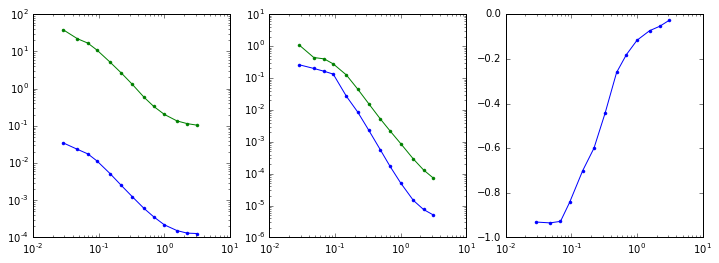

In [3]:
plt.figure(figsize=(12,4))

sty = '.-'

plt.subplot(131)
plt.loglog(model_k,gong_P_kjy_per_sr_lowerlimit_model_k,sty)
plt.loglog(model_k,gong_P_kjy_per_sr_upperlimit_model_k,sty)

plt.subplot(132)
plt.loglog(model_k,pober_P_K_lowerlimit_model_k,sty)
plt.loglog(model_k,pober_P_K_upperlimit_model_k,sty)

plt.subplot(133)
plt.semilogx(model_k,ccc_model_k,sty)

In [4]:
# simulated cube params

dk,kmax = np.min(model_k),np.max(model_k) # 1/Mpc

#https://www.evernote.com/shard/s316/nl/2147483647/988133d9-220b-44a3-b3a9-ae71353b3bd2/
Delta_x = 2.*pi/dk
dx = pi/kmax
N = int(Delta_x/dx)

D = 9000.
z = 7.
H0 = 2.269e-18 # 1/sec
Ez = sqrt(.3*(1+z)**3)
Hz = H0*Ez
Mpc2m = 1.e6*3.e16
c = 3.e8/Mpc2m # m/sec
dtheta_rad = dx/D
dtheta_amin = dtheta_rad*60*60
dz = dx*Hz/c
Delta_z = N*dz

print('kmin,kmax = %1.3e, %1.3e'%(dk,kmax))
print('dtheta_amin = %1.3f'%dtheta_amin)
print('dz = %1.3f'%dz)
print('Delta_z = %1.3f'%Delta_z)
print('dx = %d, N*dx = %d'%(dx,N*dx))

kmin,kmax = 2.869e-02, 3.114e+00
dtheta_amin = 0.403
dz = 0.003
Delta_z = 0.616
dx = 1, N*dx = 218


In [5]:
cube21_ft,cubelya_ft = np.zeros((N,N,N),dtype=complex),np.zeros((N,N,N),dtype=complex)

kvals = np.fft.fftfreq(N,1)*N*dk
kxgrid,kygrid,kzgrid = np.meshgrid(kvals,kvals,kvals)
kmaggrid = np.sqrt(kxgrid**2+kygrid**2+kzgrid**2)

In [14]:
# simulate the correlated random fields
# https://www.evernote.com/shard/s316/nl/2147483647/890d2542-53a6-4482-aebe-c13467f1ba67/

V = (dx*N)**3
# P21_grid = V*np.interp(kmaggrid,model_k,pober_P_K_upperlimit_model_k)
# Ply_grid = V*np.interp(kmaggrid,model_k,gong_P_kjy_per_sr_upperlimit_model_k)
P21_grid = V*np.interp(kmaggrid,model_k,pober_P_K_lowerlimit_model_k)
Ply_grid = V*np.interp(kmaggrid,model_k,gong_P_kjy_per_sr_lowerlimit_model_k)
ccc_grid = np.interp(kmaggrid,model_k,ccc_model_k)

sigma_beta = sqrt(Ply_grid)
a = ccc_grid*sqrt(P21_grid*Ply_grid)/sigma_beta**2
sigma_alpha = sqrt(P21_grid-a**2*sigma_beta**2)

alpha = sigma_alpha*(np.random.randn(N,N,N)+1j*np.random.randn(N,N,N))/sqrt(2)
beta = sigma_beta*(np.random.randn(N,N,N)+1j*np.random.randn(N,N,N))/sqrt(2)

cube_21_ft = alpha+a*beta
cube_ly_ft = beta

# the sqrt(2) corrects the power for taking the real part
cube_21 = sqrt(2.)*N**3*np.real(np.fft.ifftn(cube_21_ft))*dk**3/(2.*pi)**3 # should really take the real part to enforce conjugate symmetry in fourier space
cube_ly = sqrt(2.)*N**3*np.real(np.fft.ifftn(cube_ly_ft))*dk**3/(2.*pi)**3

In [15]:
kbins_3D,xspec_3D,pspec_ly_3D,pspec_21_3D,bin_counts_3D = utils.calc_3D_xspec(cube_ly,cube_21,dx,15,\
                                                        np.min(kmaggrid[kmaggrid!=0]),\
                                                        np.max(kmaggrid),uselogbins=True,\
                                                        usehann=True)

5.3694588646


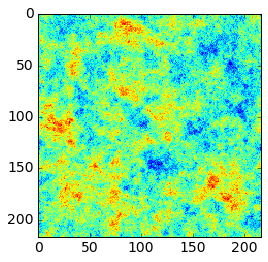

In [16]:
plt.imshow(cube_21[50,:,:],interpolation='nearest')

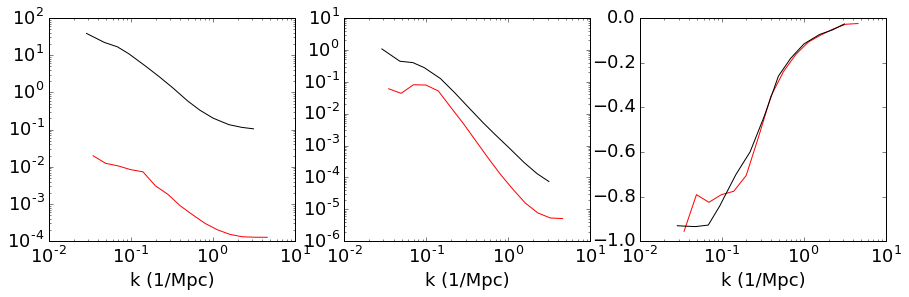

In [17]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.loglog(kbins_3D,pspec_ly_3D,'r')
plt.loglog(model_k,gong_P_kjy_per_sr_upperlimit_model_k,'k')
plt.xlabel('k (1/Mpc)')

plt.subplot(132)
plt.loglog(kbins_3D,pspec_21_3D,'r')
plt.loglog(model_k,pober_P_K_upperlimit_model_k,'k')
plt.xlabel('k (1/Mpc)')

plt.subplot(133)
plt.semilogx(kbins_3D,xspec_3D/sqrt(pspec_ly_3D*pspec_21_3D),'r')
plt.semilogx(model_k,ccc_model_k,'k')
plt.xlabel('k (1/Mpc)')

In [18]:
# let's try averaging over redshift and calculating the power spectrum and correlation vs \ell

img_ly = np.mean(cube_ly,axis=0)
img_21 = np.mean(cube_21,axis=0)
imp.reload(utils)
lbins_2D,xspec_2D,pspec_ly_2D,pspec_21_2D,bin_counts_2D = utils.calc_2D_xspec(img_ly,img_21,\
                                                                       dtheta_rad,nbins=10,lmin=300,lmax=35000,\
                                                                       uselogbins=True,usehann=True)

dl = 258
lmax = 39457



In [19]:
# lbins_2D_upper,xspec_2D_upper,pspec_ly_2D_upper,pspec_21_2D_upper,bin_counts_2D_upper = lbins_2D,xspec_2D,pspec_ly_2D,pspec_21_2D,bin_counts_2D
lbins_2D_lower,xspec_2D_lower,pspec_ly_2D_lower,pspec_21_2D_lower,bin_counts_2D_lower = lbins_2D,xspec_2D,pspec_ly_2D,pspec_21_2D,bin_counts_2D

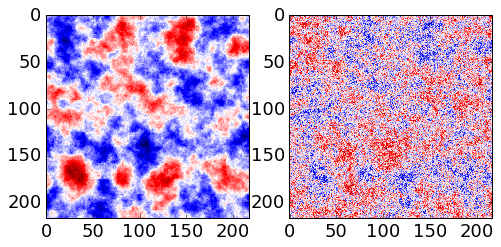

In [20]:
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(img_21,interpolation='nearest',cmap='seismic')
plt.subplot(122)
plt.imshow(img_ly,interpolation='nearest',cmap='seismic')

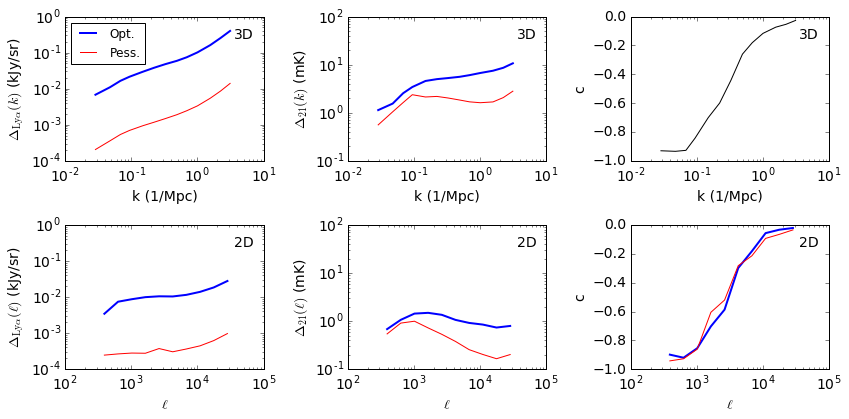

In [29]:
matplotlib.rcParams.update({'font.size': 14})

plt.figure(figsize=(12,6))

stys = ['r-','b-']
lws = [1,2]
a = .85

plt.subplot(231)
plt.loglog(model_k,sqrt(model_k**3/(2*np.pi**2)*gong_P_kjy_per_sr_upperlimit_model_k),stys[1],linewidth=lws[1],label='Opt.')
plt.loglog(model_k,sqrt(model_k**3/(2*np.pi**2)*gong_P_kjy_per_sr_lowerlimit_model_k),stys[0],linewidth=lws[0],label='Pess.')
plt.legend(fontsize=12,loc=2)
plt.xlabel('k (1/Mpc)')
plt.ylabel('$\Delta_{\mathrm{Ly}\\alpha}(k)$ (kJy/sr)')
plt.ylim([1.e-4,1])
ax = plt.gca()
plt.text(a,a,'3D',transform=ax.transAxes)

plt.subplot(232)
plt.loglog(model_k,sqrt(model_k**3/(2*np.pi**2)*pober_P_K_upperlimit_model_k)*1.e3,stys[1],linewidth=lws[1])
plt.loglog(model_k,sqrt(model_k**3/(2*np.pi**2)*pober_P_K_lowerlimit_model_k)*1.e3,stys[0],linewidth=lws[0])
plt.xlabel('k (1/Mpc)')
plt.ylabel('$\Delta_{21}(k)$ (mK)')
plt.ylim([1.e-1,1.e2])
ax = plt.gca()
plt.text(a,a,'3D',transform=ax.transAxes)

plt.subplot(233)
plt.semilogx(model_k,ccc_model_k,'k')
plt.xlabel('k (1/Mpc)')
plt.ylabel('c')
plt.ylim([-1,0])
ax = plt.gca()
plt.text(a,a,'3D',transform=ax.transAxes)

plt.subplot(234)
plt.loglog(lbins_2D_upper,sqrt(lbins_2D_upper**2/(2*np.pi)*pspec_ly_2D_upper),stys[1],linewidth=lws[1])
plt.loglog(lbins_2D_lower,sqrt(lbins_2D_lower**2/(2*np.pi)*pspec_ly_2D_lower),stys[0],linewidth=lws[0])
plt.xlabel('$\ell$')
plt.ylabel('$\Delta_{\mathrm{Ly}\\alpha}(\ell)$ (kJy/sr)')
plt.ylim([1.e-4,1])
ax = plt.gca()
plt.text(a,a,'2D',transform=ax.transAxes)

plt.subplot(235)
plt.loglog(lbins_2D_upper,sqrt(lbins_2D_upper**2/(2*np.pi)*pspec_21_2D_upper)*1.e3,stys[1],linewidth=lws[1])
plt.loglog(lbins_2D_lower,sqrt(lbins_2D_lower**2/(2*np.pi)*pspec_21_2D_lower)*1.e3,stys[0],linewidth=lws[0])
plt.xlabel('$\ell$')
plt.ylabel('$\Delta_{21}(\ell)$ (mK)')
plt.ylim([1.e-1,1.e2])
ax = plt.gca()
plt.text(a,a,'2D',transform=ax.transAxes)

plt.subplot(236)
plt.semilogx(lbins_2D_upper,xspec_2D_upper/sqrt(pspec_ly_2D_upper*pspec_21_2D_upper),stys[1],linewidth=lws[1])
plt.semilogx(lbins_2D_lower,xspec_2D_lower/sqrt(pspec_ly_2D_lower*pspec_21_2D_lower),stys[0],linewidth=lws[0])
plt.ylim([-1,0])
plt.xlabel('$\ell$')
plt.ylabel('c')
ax = plt.gca()
plt.text(a,a,'2D',transform=ax.transAxes)

plt.tight_layout()
plt.savefig('spectra3D_to_2D.pdf',bbox_inches='tight')

In [ ]:
# import pickle
# pickle.dump([lbins_2D,pspec_ly_2D,pspec_21_2D,xspec_2D,'mK^2, (kJy/sr)^2, (mK kJy)'],open('2D_21cm_and_IR_spectra_from_3D_sims_opt.p','wb'))